In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import joblib
import os

In [3]:
print("1. VERIFICANDO ESTADO ACTUAL DE MODELOS")
model_files = ["app/model.joblib", "app/model_cv.joblib"]

for model_file in model_files:
    if os.path.exists(model_file):
        file_size = os.path.getsize(model_file)
        print(f" {model_file}: {file_size} bytes")
        
        if file_size > 0:
            try:
                model = joblib.load(model_file)
                print(f"    Carga correcta - Tipo: {type(model)}")
            except Exception as e:
                print(f"    Error cargando: {e}")
        else:
            print(f"    ARCHIVO VACÍO")
    else:
        print(f" {model_file}: NO EXISTE")

1. VERIFICANDO ESTADO ACTUAL DE MODELOS
 app/model.joblib: 188266 bytes
    Carga correcta - Tipo: <class 'sklearn.pipeline.Pipeline'>
 app/model_cv.joblib: 190794 bytes
    Carga correcta - Tipo: <class 'sklearn.pipeline.Pipeline'>


In [4]:
print("\nCARGANDO Y PREPARANDO DATOS")
try:
    df = pd.read_csv("heart.csv")
    print(f" Dataset cargado: {df.shape}")
    
    # Detectar target
    def detect_target_column(df):
        possible_targets = ['HeartDisease', 'target', 'disease', 'class', 'output']
        for col in possible_targets:
            if col in df.columns:
                return col
        return df.columns[-1]
    
    target_column = detect_target_column(df)
    print(f" Columna target: '{target_column}'")
    
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Preprocesamiento
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    
    # División estratificada
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f" Datos preparados:")
    print(f"   X_train: {X_train.shape}, X_test: {X_test.shape}")
    print(f"   y_train: {y_train.value_counts().to_dict()}")
    print(f"   y_test: {y_test.value_counts().to_dict()}")
    
except Exception as e:
    print(f" Error: {e}")
    raise


CARGANDO Y PREPARANDO DATOS
 Dataset cargado: (918, 12)
 Columna target: 'HeartDisease'
 Datos preparados:
   X_train: (734, 15), X_test: (184, 15)
   y_train: {1: 406, 0: 328}
   y_test: {1: 102, 0: 82}


In [5]:
print("\nCREANDO MODELO SIMPLE (model.joblib)")
# Crear pipeline para modelo simple
simple_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))
])

print(" Entrenando modelo simple...")
simple_pipeline.fit(X_train, y_train)

# Evaluar
y_pred_simple = simple_pipeline.predict(X_test)
y_pred_proba_simple = simple_pipeline.predict_proba(X_test)[:, 1]

auc_simple = roc_auc_score(y_test, y_pred_proba_simple)
accuracy_simple = accuracy_score(y_test, y_pred_simple)

print(f" Performance modelo simple:")
print(f"   AUC: {auc_simple:.4f}")
print(f"   Accuracy: {accuracy_simple:.4f}")

# Guardar
joblib.dump(simple_pipeline, "app/model.joblib")
print(" model.joblib guardado correctamente")


CREANDO MODELO SIMPLE (model.joblib)
 Entrenando modelo simple...


 Performance modelo simple:
   AUC: 0.9322
   Accuracy: 0.8750
 model.joblib guardado correctamente


In [6]:
print("\nCREANDO MODELO OPTIMIZADO (model_cv.joblib)")
# Configurar GridSearch para GradientBoosting
gb_model = GradientBoostingClassifier(random_state=42)

gb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", gb_model)
])

gb_params = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [3, 4],
    "clf__min_samples_split": [2, 5]
}

print(" Optimizando modelo con GridSearchCV...")
gb_grid = GridSearchCV(
    gb_pipeline, 
    gb_params, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train, y_train)

# Resultados
print(f" Mejores parámetros: {gb_grid.best_params_}")

# Evaluar modelo optimizado
best_gb_model = gb_grid.best_estimator_
y_pred_gb = best_gb_model.predict(X_test)
y_pred_proba_gb = best_gb_model.predict_proba(X_test)[:, 1]

auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

print(f" Performance modelo optimizado:")
print(f"   AUC: {auc_gb:.4f}")
print(f"   Accuracy: {accuracy_gb:.4f}")
print(f"   Mejora vs simple: {auc_gb - auc_simple:.4f}")

# Guardar modelo optimizado
joblib.dump(best_gb_model, "app/model_cv.joblib")
print(" model_cv.joblib guardado correctamente")


CREANDO MODELO OPTIMIZADO (model_cv.joblib)
 Optimizando modelo con GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
 Mejores parámetros: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
 Performance modelo optimizado:
   AUC: 0.9393
   Accuracy: 0.8967
   Mejora vs simple: 0.0071
 model_cv.joblib guardado correctamente



VERIFICACIÓN FINAL Y COMPARACIÓN
 VERIFICANDO ARCHIVOS GUARDADOS:
 app/model.joblib: 188266 bytes - FUNCIONAL
   Tipo: <class 'sklearn.pipeline.Pipeline'>
   Puede predecir: 2 probabilidades
 app/model_cv.joblib: 190794 bytes - FUNCIONAL
   Tipo: <class 'sklearn.pipeline.Pipeline'>
   Puede predecir: 2 probabilidades

 COMPARACIÓN DE MODELOS:
   Modelo Simple:    AUC = 0.9322, Accuracy = 0.8750
   Modelo Optimizado: AUC = 0.9393, Accuracy = 0.8967
   Mejora:           AUC = 0.0071


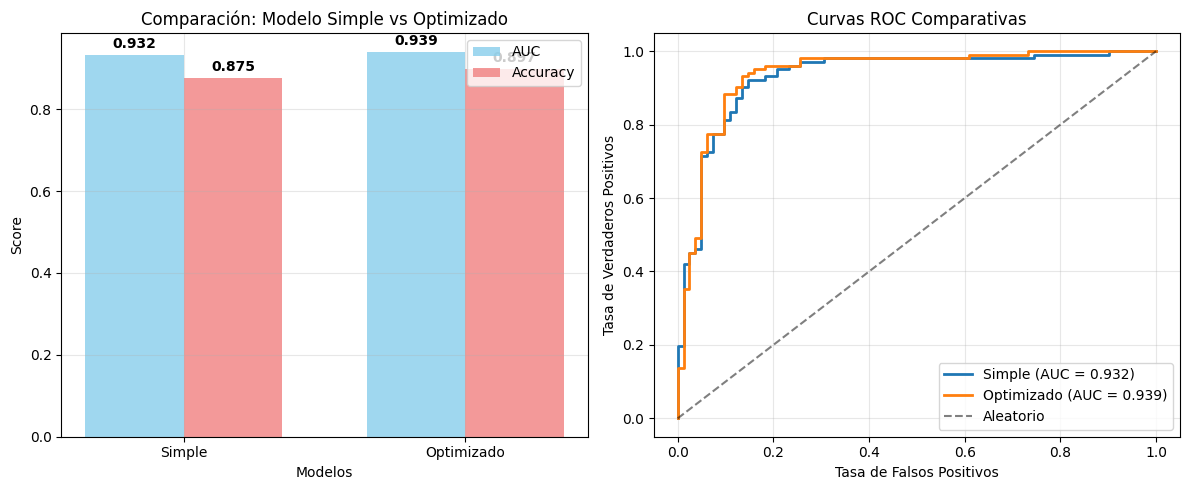

In [7]:
print("\nVERIFICACIÓN FINAL Y COMPARACIÓN")

# Verificar que los archivos existen y funcionan
print(" VERIFICANDO ARCHIVOS GUARDADOS:")

for model_file in model_files:
    if os.path.exists(model_file):
        file_size = os.path.getsize(model_file)
        try:
            model = joblib.load(model_file)
            # Probar predicción
            test_pred = model.predict_proba(X_test.iloc[0:1])[0]
            print(f" {model_file}: {file_size} bytes - FUNCIONAL")
            print(f"   Tipo: {type(model)}")
            print(f"   Puede predecir: {len(test_pred)} probabilidades")
        except Exception as e:
            print(f" {model_file}: ERROR - {e}")
    else:
        print(f" {model_file}: NO EXISTE")

# Comparación de performance
print(f"\n COMPARACIÓN DE MODELOS:")
print(f"   Modelo Simple:    AUC = {auc_simple:.4f}, Accuracy = {accuracy_simple:.4f}")
print(f"   Modelo Optimizado: AUC = {auc_gb:.4f}, Accuracy = {accuracy_gb:.4f}")
print(f"   Mejora:           AUC = {auc_gb - auc_simple:.4f}")

# Visualización comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico 1: Comparación de métricas
models = ['Simple', 'Optimizado']
auc_scores = [auc_simple, auc_gb]
acc_scores = [accuracy_simple, accuracy_gb]

x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, auc_scores, width, label='AUC', color='skyblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, acc_scores, width, label='Accuracy', color='lightcoral', alpha=0.8)

ax1.set_xlabel('Modelos')
ax1.set_ylabel('Score')
ax1.set_title('Comparación: Modelo Simple vs Optimizado')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Añadir valores en las barras
for bar, value in zip(bars1, auc_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
for bar, value in zip(bars2, acc_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Curvas ROC
from sklearn.metrics import roc_curve

fpr_simple, tpr_simple, _ = roc_curve(y_test, y_pred_proba_simple)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)

ax2.plot(fpr_simple, tpr_simple, label=f'Simple (AUC = {auc_simple:.3f})', linewidth=2)
ax2.plot(fpr_gb, tpr_gb, label=f'Optimizado (AUC = {auc_gb:.3f})', linewidth=2)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Aleatorio')

ax2.set_xlabel('Tasa de Falsos Positivos')
ax2.set_ylabel('Tasa de Verdaderos Positivos')
ax2.set_title('Curvas ROC Comparativas')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
print("\n6INSTRUCCIONES DE USO")

print(" MODELOS CREADOS EXITOSAMENTE:")
print("   1. app/model.joblib - Modelo simple para desarrollo")
print("   2. app/model_cv.joblib - Modelo optimizado para producción")

print("\n CÓMO USAR EN CÓDIGO:")
print("""
# Cargar modelo
import joblib
model = joblib.load("app/model.joblib")

# Hacer predicción
prediccion = model.predict(nuevos_datos)
probabilidades = model.predict_proba(nuevos_datos)
""")

print("\n PRÓXIMOS PASOS:")
print("   1. Ejecutar notebooks/1_model_leakage_demo.ipynb")
print("   2. Ejecutar notebooks/2_model_pipeline_cv.ipynb") 
print("   3. Probar la API Flask: python app/api_flask.py")


6INSTRUCCIONES DE USO
 MODELOS CREADOS EXITOSAMENTE:
   1. app/model.joblib - Modelo simple para desarrollo
   2. app/model_cv.joblib - Modelo optimizado para producción

 CÓMO USAR EN CÓDIGO:

# Cargar modelo
import joblib
model = joblib.load("app/model.joblib")

# Hacer predicción
prediccion = model.predict(nuevos_datos)
probabilidades = model.predict_proba(nuevos_datos)


 PRÓXIMOS PASOS:
   1. Ejecutar notebooks/1_model_leakage_demo.ipynb
   2. Ejecutar notebooks/2_model_pipeline_cv.ipynb
   3. Probar la API Flask: python app/api_flask.py
